# SDG&E Test System Data Preprocessing

This notebook is used to preprocess the data needed to create the San Diego test system model.

In [44]:
# Libraries
import pylab as plt
import importlib
import os
from os.path import join
import networkx as nx
import numpy as np

# Modules
import utils
import graph_tools
importlib.reload(utils)
importlib.reload(graph_tools)
from utils import *
from graph_tools import subset_system

# Path the data directory
DATA_DIR = join(os.getcwd(), 'data')

In [3]:
# Read all CATS datasets (standardizing column names where needed)
buses = (read_geocsv('CATS_buses.csv')
         .rename(columns={'bus_i':'bus'})
        )

lines = (gpd
         .read_file(join(DATA_DIR, 'cats', 'CATS_lines.json'))
         .pipe(standardize)
         .rename(columns={'cats_id':'id', 'br_r':'r', 'br_x':'x', 'br_b':'b'})
        )

loads = read_loads('loads.csv')

gens = (read_mat('gencost.mat')
        .join(read_csv('CATS_generators.csv'))
        .pipe(add_id)
        )

# Read IOU shapefile and select SDG&E shape
ious = gpd.read_file(join(PATH, 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

In [46]:
# Create a sub-system of lines, buses, and gens 
# Save all outputs to CSVs in the test-system folder
sub_lines, sub_buses, sub_gens = subset_system(sdge, lines, buses, gens, loads)

Created a system with 489 buses. Removed 2 isolated buses.


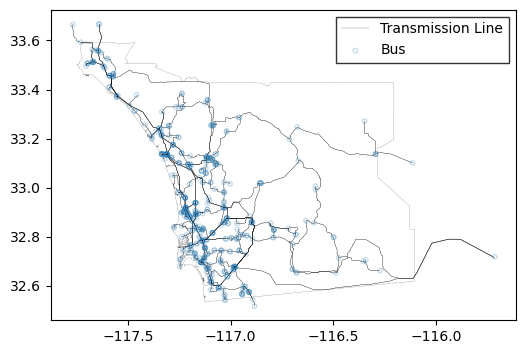

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
gpd.GeoDataFrame(sub_lines, geometry="geometry").plot(ax=ax, color='k', lw=0.15, label="Transmission Line")
sub_buses.plot(ax=ax, zorder=2, alpha=0.25, facecolor='none', edgecolor='C0',  markersize=10, label="Bus")
sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw = 0.1)
plt.legend(fancybox=False, edgecolor='k')
#plt.savefig("test_system.svg")

In [38]:
# Check that the subsystem is fully connected
graph = nx.from_pandas_edgelist(sub_lines, source='f_bus', target='t_bus')
print("System Connected:", 1==len(list(nx.connected_components(graph))))

System Connected: True


In [40]:
sub_lines

,f_bus,t_bus,rate_a,sus,geometry
0,1,4,118.0,3999.568333,"LINESTRING (-117.67 33.563, -117.67 33.563, -1..."
1,1,120,250.0,7537.724574,"LINESTRING (-117.62 33.499, -117.63 33.5, -117..."
2,1,177,118.0,71740.627046,"LINESTRING (-117.67 33.513, -117.67 33.512, -1..."
3,1,179,219.0,5654.086233,"LINESTRING (-117.62 33.496, -117.62 33.499, -1..."
4,1,186,317.0,87473.128467,"LINESTRING (-117.67 33.512, -117.67 33.512, -1..."
...,...,...,...,...,...
1207,488,325,308.0,62463.048527,"LINESTRING (-117.14 32.695, -117.14 32.696, -1..."
1208,488,489,313.0,2871.039257,"LINESTRING (-117.14 32.697, -117.14 32.697)"
1209,489,454,230.0,10948.608212,"LINESTRING (-117.14 32.696, -117.14 32.697, -1..."
1210,489,487,529.0,4852.802849,"LINESTRING (-117.14 32.696, -117.14 32.697)"
